# 🖥️ System and GPU Benchmark

A minimal benchmark to test your system's CPU and GPU performance, with improved detection for dual-GPU laptops.

In [1]:
# Standard library imports for system information
import os
import sys
import platform
import subprocess

# Advanced PyTorch Benchmark with robust visualization
import torch
from torch.utils.benchmark import Timer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import PyTorch for benchmarking

# Set seaborn style for prettier plots
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# Set up better aesthetics
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Arial",
    "DejaVu Sans",
    "Liberation Sans",
    "Bitstream Vera Sans",
    "sans-serif",
]

# Custom color palette
colors = {
    "cpu": "#3498db",
    "gpu": "#e74c3c",
    "speedup": "#2ecc71",
    "background": "#f9f9f9",
    "text": "#2c3e50",
    "grid": "#ecf0f1",
}

## 📋 System Information

Let's gather basic information about your system hardware and Python environment.

In [3]:
def print_header(title):
    """Print a section header"""
    print(f"\n{'=' * 80}")
    print(f"{title.center(80)}")
    print(f"{'=' * 80}\n")


def print_info(label, info):
    """Print a formatted label and info"""
    print(f"{label.ljust(25)}: {info}")

In [4]:
print_header("SYSTEM INFORMATION")

# OS and platform information
uname = platform.uname()
print_info("OS", f"{uname.system} {uname.release}")
print_info("OS Version", uname.version)
print_info("Machine", uname.machine)

# CPU information
print_info("Processor", uname.processor)
print_info("CPU Count (logical)", os.cpu_count())

# Try to get better CPU info on Windows
try:
    if platform.system() == "Windows":
        import ctypes

        ctypes.windll.kernel32.GetSystemFirmwareTable.restype = ctypes.c_void_p
        result = (
            subprocess.check_output("wmic cpu get name", shell=True)
            .decode()
            .strip()
            .split("\n")[1]
        )
        print_info("CPU Model", result)
except Exception:
    pass  # Fall back to the basic information if this fails

# Python information
print_info(
    "Python Version",
    f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}",
)
print_info("Python Executable", sys.executable)
print_info("PyTorch Version", torch.__version__)

# Memory information
try:
    if platform.system() == "Windows":
        import ctypes

        kernel32 = ctypes.windll.kernel32
        c_ulonglong = ctypes.c_ulonglong

        class MEMORYSTATUSEX(ctypes.Structure):
            _fields_ = [
                ("dwLength", ctypes.c_ulong),
                ("dwMemoryLoad", ctypes.c_ulong),
                ("ullTotalPhys", c_ulonglong),
                ("ullAvailPhys", c_ulonglong),
                ("ullTotalPageFile", c_ulonglong),
                ("ullAvailPageFile", c_ulonglong),
                ("ullTotalVirtual", c_ulonglong),
                ("ullAvailVirtual", c_ulonglong),
                ("ullExtendedVirtual", c_ulonglong),
            ]

        memoryStatus = MEMORYSTATUSEX()
        memoryStatus.dwLength = ctypes.sizeof(MEMORYSTATUSEX)
        kernel32.GlobalMemoryStatusEx(ctypes.byref(memoryStatus))
        mem_gib = memoryStatus.ullTotalPhys / (1024.0**3)
        print_info("System RAM", f"{mem_gib:.2f} GiB")
        print_info("Memory Usage", f"{memoryStatus.dwMemoryLoad}%")
    elif (
        hasattr(os, "sysconf")
        and os.sysconf_names.get("SC_PHYS_PAGES", None) is not None
    ):
        # Linux/Unix
        mem_bytes = os.sysconf("SC_PHYS_PAGES") * os.sysconf("SC_PAGE_SIZE")
        mem_gib = mem_bytes / (1024.0**3)
        print_info("System RAM", f"{mem_gib:.2f} GiB")
except Exception:
    print_info("System RAM", "Could not detect")


                               SYSTEM INFORMATION                               

OS                       : Linux 6.12.42
OS Version               : #1-NixOS SMP PREEMPT_DYNAMIC Fri Aug 15 10:14:14 UTC 2025
Machine                  : x86_64
Processor                : 
CPU Count (logical)      : 16
Python Version           : 3.12.11
Python Executable        : /home/yrrrrrf/lab/ai/.venv/bin/python
PyTorch Version          : 2.6.0+cu124
System RAM               : 30.57 GiB


## 🔍 GPU Information

Let's check for available GPUs using multiple detection methods.

In [5]:
print_header("GPU INFORMATION")

# Method 1: PyTorch CUDA detection
print("Method 1: PyTorch CUDA detection")
print_info("CUDA Available", torch.cuda.is_available())
print_info(
    "CUDA Version",
    torch.version.cuda if hasattr(torch.version, "cuda") else "Not detected",
)

if torch.cuda.is_available():
    print_info("GPU Count", torch.cuda.device_count())

    # Get information for each GPU
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}:")
        print_info("  Name", torch.cuda.get_device_name(i))
        print_info(
            "  Capability",
            f"{torch.cuda.get_device_capability(i)[0]}.{torch.cuda.get_device_capability(i)[1]}",
        )

        # Get memory information if available
        try:
            total_mem = torch.cuda.get_device_properties(i).total_memory / (1024.0**3)
            print_info("  Memory", f"{total_mem:.2f} GiB")
        except:
            pass
else:
    print("PyTorch CUDA detection: No CUDA-compatible GPU detected.")

# Method 2: Try to detect GPUs using Windows commands on Windows systems
if platform.system() == "Windows":
    print("\nMethod 2: Windows command-line detection")
    try:
        # Using wmic to detect NVIDIA GPUs
        nvidia_output = (
            subprocess.check_output(
                "wmic path win32_VideoController get name", shell=True
            )
            .decode()
            .strip()
            .split("\n")
        )
        nvidia_output = [
            line.strip()
            for line in nvidia_output
            if line.strip() and line.strip() != "Name"
        ]

        if nvidia_output:
            print("\nDetected Graphics Cards:")
            for i, gpu in enumerate(nvidia_output):
                print_info(f"GPU {i}", gpu)

            # Look for NVIDIA GPUs that might work with CUDA
            nvidia_gpus = [
                gpu
                for gpu in nvidia_output
                if "NVIDIA" in gpu
                or "GeForce" in gpu
                or "Quadro" in gpu
                or "RTX" in gpu
                or "GTX" in gpu
            ]
            amd_gpus = [gpu for gpu in nvidia_output if "AMD" in gpu or "Radeon" in gpu]

            if nvidia_gpus:
                print("\nDetected NVIDIA GPUs (potentially CUDA-compatible):")
                for i, gpu in enumerate(nvidia_gpus):
                    print_info(f"NVIDIA GPU {i}", gpu)

            if amd_gpus:
                print("\nDetected AMD GPUs:")
                for i, gpu in enumerate(amd_gpus):
                    print_info(f"AMD GPU {i}", gpu)
        else:
            print("No GPUs detected via Windows command line.")
    except Exception as e:
        print(f"Error detecting GPUs via Windows command line: {e}")

# Method 3: Try a more direct approach with CUDA initialization (if not already detected)
if not torch.cuda.is_available():
    print("\nMethod 3: Manual CUDA initialization attempt")
    try:
        # Try to explicitly initialize CUDA
        if torch.version.cuda is not None:
            torch.cuda.init()
            print("Manual CUDA initialization: Success")
            print_info("CUDA Available After Init", torch.cuda.is_available())
            if torch.cuda.is_available():
                print_info("GPU Count", torch.cuda.device_count())
                for i in range(torch.cuda.device_count()):
                    print_info(f"GPU {i} Name", torch.cuda.get_device_name(i))
        else:
            print(
                "Manual CUDA initialization: Failed (CUDA not found in this PyTorch build)"
            )
            print("Your PyTorch installation might not include CUDA support.")
    except Exception as e:
        print(f"Manual CUDA initialization error: {e}")

# Final determination about GPU availability
print("\nFinal GPU Status:")
if torch.cuda.is_available():
    print("✓ CUDA-capable GPU is available and working with PyTorch")
    for i in range(torch.cuda.device_count()):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")
elif platform.system() == "Windows" and any(
    "NVIDIA" in gpu for gpu in locals().get("nvidia_output", [])
):
    print("⚠ NVIDIA GPU detected by Windows, but not accessible by PyTorch")
    print("This typically means one of the following:")
    print("  1. Your PyTorch installation was not built with CUDA support")
    print("  2. Your NVIDIA drivers need to be updated")
    print("  3. Your laptop may be using Optimus/hybrid graphics where the NVIDIA GPU")
    print("     is not directly accessible, or has been disabled in power settings")
    nvidia_gpus = [
        gpu
        for gpu in nvidia_output
        if "NVIDIA" in gpu
        or "GeForce" in gpu
        or "Quadro" in gpu
        or "RTX" in gpu
        or "GTX" in gpu
    ]
    for gpu in nvidia_gpus:
        print(f"  - Detected NVIDIA GPU: {gpu}")
else:
    print("✗ No CUDA-capable GPU detected or accessible")


                                GPU INFORMATION                                 

Method 1: PyTorch CUDA detection
CUDA Available           : True
CUDA Version             : 12.4
GPU Count                : 1

GPU 0:
  Name                   : NVIDIA GeForce RTX 4060 Laptop GPU
  Capability             : 8.9
  Memory                 : 7.63 GiB

Final GPU Status:
✓ CUDA-capable GPU is available and working with PyTorch
  - GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


⚡ GPU PERFORMANCE DASHBOARD ⚡

🧮 Linear Algebra Operations
⏱️  Testing: Matrix Multiplication (512×512)
   CPU: 0.003578s ± 0.003570s  |  GPU: 0.000070s ± 0.000069s  |  Speedup: 51.43x
⏱️  Testing: Matrix Multiplication (1024×1024)
   CPU: 0.029209s ± 0.029135s  |  GPU: 0.000399s ± 0.000396s  |  Speedup: 73.14x
⏱️  Testing: Matrix Multiplication (4096×4096)
   CPU: 1.540110s ± 1.540110s  |  GPU: 0.021615s ± 0.021573s  |  Speedup: 71.25x

🧠 Neural Network Layers
⏱️  Testing: Conv2d (64 filters, 3×3, 224×224 image)
   CPU: 0.226172s ± 0.225369s  |  GPU: 0.001675s ± 0.001678s  |  Speedup: 135.05x
⏱️  Testing: ReLU (10M elements)
   CPU: 0.063453s ± 0.063750s  |  GPU: 0.000506s ± 0.000506s  |  Speedup: 125.37x
⏱️  Testing: BatchNorm2d (100 images)
   CPU: 0.162991s ± 0.161954s  |  GPU: 0.001498s ± 0.001485s  |  Speedup: 108.82x

📊 Data Processing
⏱️  Testing: Element-wise Operations (10M elements)
   CPU: 0.200666s ± 0.199982s  |  GPU: 0.002265s ± 0.002265s  |  Speedup: 88.60x


/tmp/ipykernel_28745/682833805.py:320: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_28745/682833805.py:320: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/yrrrrrf/lab/ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yrrrrrf/lab/ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


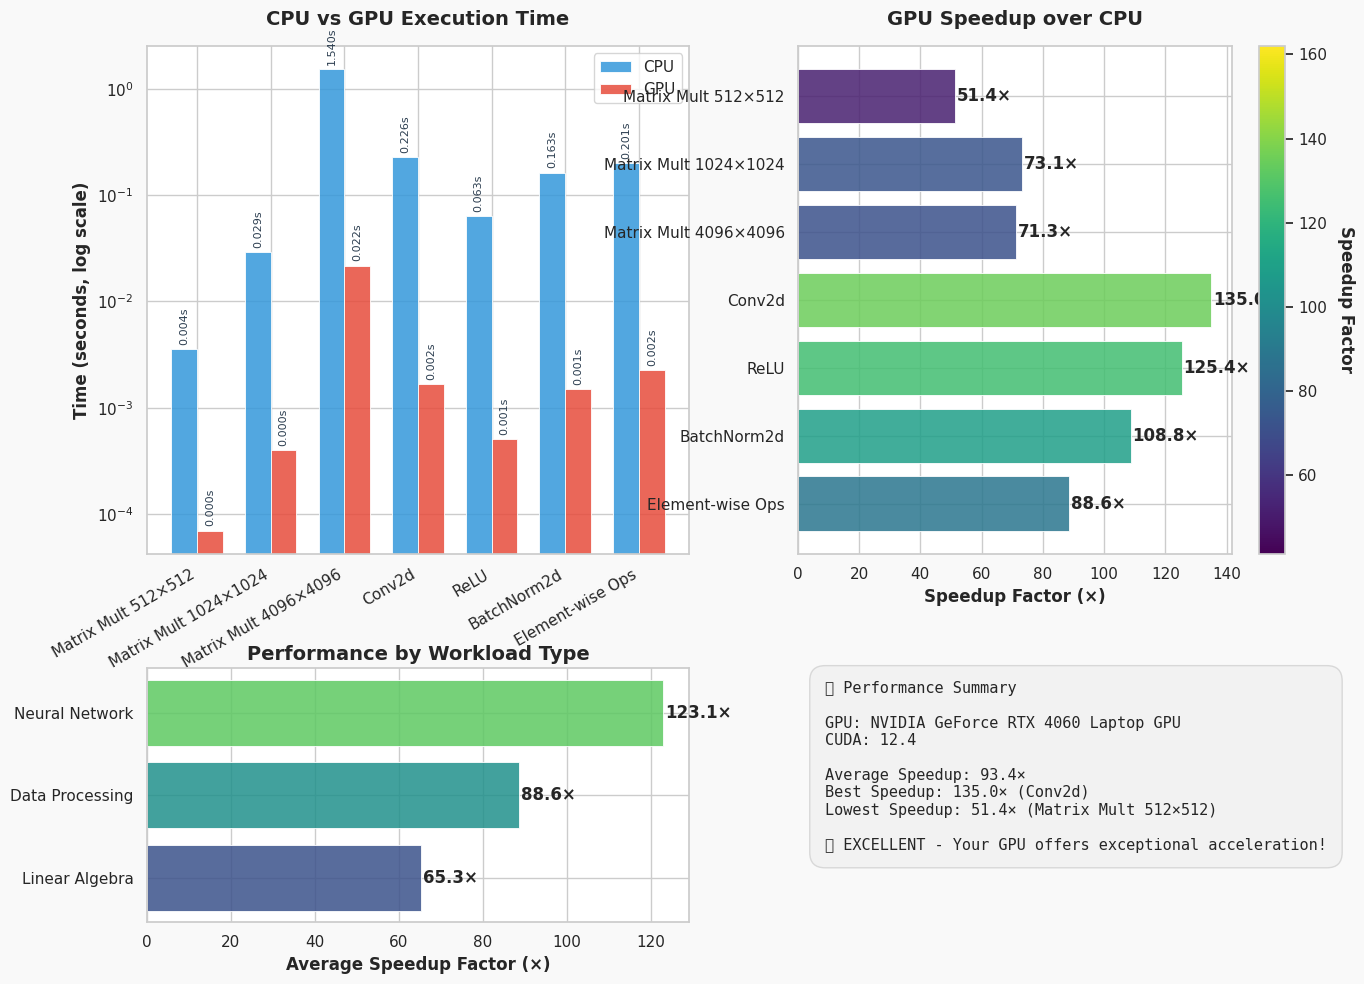


🏆 GPU PERFORMANCE RATING: 📈 EXCELLENT
GPU provides an average 93.4× speedup across all benchmarks.


In [6]:
print("⚡ GPU PERFORMANCE DASHBOARD ⚡")


def run_benchmark(name, cpu_code, gpu_code, repeats=5, sub_label=None, short_name=None):
    """Run a benchmark on both CPU and GPU with elegant timing"""
    print(f"⏱️  Testing: {name}")

    if short_name is None:
        # Extract short name safely without pandas
        parts = name.split(" (")
        short_name = parts[0] if len(parts) > 0 else name

    # CPU benchmark
    cpu_timer = Timer(
        stmt=cpu_code,
        globals=globals(),
    )
    cpu_result = cpu_timer.blocked_autorange(min_run_time=1.0)

    # GPU benchmark (if available)
    if torch.cuda.is_available():
        gpu_timer = Timer(
            stmt=gpu_code,
            globals=globals(),
        )
        gpu_result = gpu_timer.blocked_autorange(min_run_time=1.0)

        # Calculate speedup
        speedup = cpu_result.mean / gpu_result.mean

        # Print results with nice formatting
        result_str = f"   CPU: {cpu_result.mean:.6f}s ± {cpu_result.median:.6f}s  |  GPU: {gpu_result.mean:.6f}s ± {gpu_result.median:.6f}s  |  Speedup: {speedup:.2f}x"
        print(result_str)

        return {
            "name": name,
            "short_name": short_name,
            "sub_label": sub_label,
            "cpu_time": cpu_result.mean,
            "cpu_std": cpu_result.median,
            "gpu_time": gpu_result.mean,
            "gpu_std": gpu_result.median,
            "speedup": speedup,
        }
    else:
        print(f"   CPU: {cpu_result.mean:.6f}s ± {cpu_result.median:.6f}s")
        return {
            "name": name,
            "short_name": short_name,
            "sub_label": sub_label,
            "cpu_time": cpu_result.mean,
            "cpu_std": cpu_result.median,
            "gpu_time": None,
            "gpu_std": None,
            "speedup": None,
        }


# Create a list to store benchmark results
results = []

print("\n🧮 Linear Algebra Operations")
# Test matrix operations at different sizes
for size in [512, 1024, 4096]:
    # Matrix multiplication
    results.append(
        run_benchmark(
            f"Matrix Multiplication ({size}×{size})",
            f"torch.matmul(torch.randn({size}, {size}), torch.randn({size}, {size}))",
            f"torch.matmul(torch.randn({size}, {size}, device='cuda'), torch.randn({size}, {size}, device='cuda')); torch.cuda.synchronize()",
            sub_label="Linear Algebra",
            short_name=f"Matrix Mult {size}×{size}",
        )
    )

print("\n🧠 Neural Network Layers")
# Test common neural network operations
# Conv2d operation
results.append(
    run_benchmark(
        "Conv2d (64 filters, 3×3, 224×224 image)",
        "torch.nn.functional.conv2d(torch.randn(16, 3, 224, 224), torch.randn(64, 3, 3, 3), padding=1)",
        "torch.nn.functional.conv2d(torch.randn(16, 3, 224, 224, device='cuda'), torch.randn(64, 3, 3, 3, device='cuda'), padding=1); torch.cuda.synchronize()",
        sub_label="Neural Network",
        short_name="Conv2d",
    )
)

# ReLU activation on large tensor
results.append(
    run_benchmark(
        "ReLU (10M elements)",
        "torch.nn.functional.relu(torch.randn(10000000))",
        "torch.nn.functional.relu(torch.randn(10000000, device='cuda')); torch.cuda.synchronize()",
        sub_label="Neural Network",
        short_name="ReLU",
    )
)

# BatchNorm on image data
results.append(
    run_benchmark(
        "BatchNorm2d (100 images)",
        "bn = torch.nn.BatchNorm2d(64); bn(torch.randn(100, 64, 56, 56))",
        "bn = torch.nn.BatchNorm2d(64).cuda(); bn(torch.randn(100, 64, 56, 56, device='cuda')); torch.cuda.synchronize()",
        sub_label="Neural Network",
        short_name="BatchNorm2d",
    )
)

print("\n📊 Data Processing")
# Element-wise operations
results.append(
    run_benchmark(
        "Element-wise Operations (10M elements)",
        "a = torch.randn(10000000); b = torch.randn(10000000); c = torch.sin(a) + torch.log(torch.abs(b) + 1)",
        "a = torch.randn(10000000, device='cuda'); b = torch.randn(10000000, device='cuda'); c = torch.sin(a) + torch.log(torch.abs(b) + 1); torch.cuda.synchronize()",
        sub_label="Data Processing",
        short_name="Element-wise Ops",
    )
)

# Create visualizations without pandas
if torch.cuda.is_available() and len(results) > 0:
    # Extract data for plotting
    names = [r["short_name"] for r in results]
    cpu_times = [r["cpu_time"] for r in results]
    gpu_times = [r["gpu_time"] for r in results]
    speedups = [r["speedup"] for r in results]
    sub_labels = [r["sub_label"] for r in results]

    # Calculate average metrics
    avg_speedup = sum(speedups) / len(speedups)
    max_speedup = max(speedups)
    min_speedup = min(speedups)

    # Find the operations with max and min speedup
    max_op = names[speedups.index(max_speedup)]
    min_op = names[speedups.index(min_speedup)]

    # Get unique categories
    unique_labels = list(set(sub_labels))

    # Calculate category averages
    cat_avg = {}
    for label in unique_labels:
        label_speedups = [s for i, s in enumerate(speedups) if sub_labels[i] == label]
        cat_avg[label] = sum(label_speedups) / len(label_speedups)

    # Create a modern dashboard with multiple visualizations
    fig = plt.figure(figsize=(14, 10), dpi=100, facecolor=colors["background"])
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

    # 1. CPU vs GPU Performance comparison (with log scale)
    ax1 = fig.add_subplot(gs[0, 0])
    bar_width = 0.35
    x = np.arange(len(names))

    # CPU bars
    ax1.bar(
        x - bar_width / 2,
        cpu_times,
        bar_width,
        color=colors["cpu"],
        label="CPU",
        alpha=0.85,
        edgecolor="white",
        linewidth=0.7,
    )

    # GPU bars
    ax1.bar(
        x + bar_width / 2,
        gpu_times,
        bar_width,
        color=colors["gpu"],
        label="GPU",
        alpha=0.85,
        edgecolor="white",
        linewidth=0.7,
    )

    # Format the plot
    ax1.set_yscale("log")
    ax1.set_ylabel("Time (seconds, log scale)", fontweight="bold")
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=30, ha="right")
    ax1.legend(frameon=True)
    ax1.set_title("CPU vs GPU Execution Time", fontsize=14, fontweight="bold", pad=15)

    # Add value labels
    for i, v in enumerate(cpu_times):
        ax1.text(
            i - bar_width / 2,
            v * 1.1,
            f"{v:.3f}s",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=8,
            color=colors["text"],
        )

    for i, v in enumerate(gpu_times):
        ax1.text(
            i + bar_width / 2,
            v * 1.1,
            f"{v:.3f}s",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=8,
            color=colors["text"],
        )

    # 2. Speedup factor chart with gradient color
    ax2 = fig.add_subplot(gs[0, 1])

    # Create a gradient color map based on speedup values
    norm = plt.Normalize(min(speedups) * 0.8, max(speedups) * 1.2)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])

    # Plot horizontal bars with gradient color
    bars = ax2.barh(
        names,
        speedups,
        color=sm.to_rgba(speedups),
        alpha=0.85,
        edgecolor="white",
        linewidth=0.7,
    )

    # Format the plot
    ax2.set_xlabel("Speedup Factor (×)", fontweight="bold")
    ax2.invert_yaxis()  # Invert to match order with first plot
    ax2.set_title("GPU Speedup over CPU", fontsize=14, fontweight="bold", pad=15)

    # Add value labels
    for i, v in enumerate(speedups):
        ax2.text(v + 0.5, i, f"{v:.1f}×", va="center", fontweight="bold")

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax2)
    cbar.set_label("Speedup Factor", rotation=270, labelpad=20, fontweight="bold")

    # 3. Speedup by category
    ax3 = fig.add_subplot(gs[1, 0])

    # Create horizontal bar chart for categories
    cat_names = list(cat_avg.keys())
    cat_values = list(cat_avg.values())

    # Sort by values
    cat_pairs = sorted(zip(cat_names, cat_values), key=lambda x: x[1])
    cat_names = [x[0] for x in cat_pairs]
    cat_values = [x[1] for x in cat_pairs]

    # Plot bars with gradient color
    bars = ax3.barh(
        cat_names,
        cat_values,
        color=sns.color_palette("viridis", len(cat_names)),
        alpha=0.85,
        edgecolor="white",
        linewidth=0.7,
    )

    # Format the plot
    ax3.set_xlabel("Average Speedup Factor (×)", fontweight="bold")
    ax3.set_ylabel("")
    ax3.set_title("Performance by Workload Type", fontsize=14, fontweight="bold")

    # Add value labels
    for i, v in enumerate(cat_values):
        ax3.text(v + 0.5, i, f"{v:.1f}×", va="center", fontweight="bold")

    # 4. Summary metrics panel
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis("off")

    # Create a fancy summary box
    gpu_name = torch.cuda.get_device_name(0)
    summary_text = (
        f"🚀 Performance Summary\n\n"
        f"GPU: {gpu_name}\n"
        f"CUDA: {torch.version.cuda}\n\n"
        f"Average Speedup: {avg_speedup:.1f}×\n"
        f"Best Speedup: {max_speedup:.1f}× ({max_op})\n"
        f"Lowest Speedup: {min_speedup:.1f}× ({min_op})\n\n"
    )

    # Performance rating based on average speedup
    if avg_speedup > 20:
        rating = "📈 EXCELLENT - Your GPU offers exceptional acceleration!"
    elif avg_speedup > 10:
        rating = "✅ GREAT - Your GPU provides strong acceleration"
    elif avg_speedup > 5:
        rating = "👍 GOOD - Your GPU offers decent acceleration"
    else:
        rating = "🔍 MODEST - Consider upgrading for deep learning tasks"

    summary_text += rating

    # Add text box with custom styling
    props = dict(
        boxstyle="round,pad=1", facecolor="#f0f0f0", alpha=0.7, edgecolor="#cccccc"
    )
    ax4.text(
        0.05,
        0.95,
        summary_text,
        transform=ax4.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox=props,
        fontfamily="monospace",
    )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()

    # Print a compact final summary
    print(f"\n🏆 GPU PERFORMANCE RATING: {rating.split(' - ')[0]}")
    print(f"GPU provides an average {avg_speedup:.1f}× speedup across all benchmarks.")

else:
    print(
        "\n❌ Cannot create performance dashboard: No CUDA-capable GPU detected or enabled."
    )
    print("Run the following command to install PyTorch with CUDA support:")
    print(
        "uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121"
    )